# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
from scipy.stats import multivariate_normal
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist


import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [29]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    
    def __init__(self, n_components, max_iter):
        self.max_iter = max_iter
        self.n_components = n_components
        self.mu = None
        self.pi = None
        self.cov = None
        
    def fit(self, X, y=None):
        dim = X.shape[1]
        
        #Из-за того что матрица ковариаций может выродиться
        self.reg_cov = 1e-6*np.identity(dim)
        
        
        #Матриц nxm с матожиданиями: n кластеров, m размерность гауссианы
        self.mu = np.random.randint(min(X[:,0]), max(X[:,0]), size=(self.n_components, dim))
        
        #Матрица ковариации nxmxm: по матрице на каждый кластер(гауссиану) - n, размерность гауссианы m 
        self.cov = np.zeros((self.n_components, dim, dim))
        for d in range(len(self.cov)):
            np.fill_diagonal(self.cov[d], 5)#5
            
        self.pi = np.ones(self.n_components)/self.n_components
        
        log_likelihoods = [] 
        
        for i in range(self.max_iter):               
            #E Step
            #Для каждой точки из Х считаем вероятность принадлежности конкретному кластеру
            r_ic = np.zeros((X.shape[0], self.n_components))
            for m, co, p, r in zip(self.mu, self.cov, self.pi, range(r_ic.shape[1])):
                co = co + self.reg_cov
                mn = multivariate_normal(mean=m, cov=co)
                r_ic[:, r] = p*mn.pdf(X)/np.sum([pi_c*multivariate_normal(mean=mu_c, cov=cov_c).pdf(X) for pi_c, mu_c, cov_c in zip(self.pi, self.mu, self.cov + self.reg_cov)], axis=0)
            
            #M Step
            #Считаем новый вектор матожиданий и новые матрицы ковариации на основе r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []
            for c in range(r_ic.shape[1]):
                m_c = np.sum(r_ic[:, c], axis=0)
                mu_c = (1/m_c)*np.sum(X*r_ic[:, c].reshape(X.shape[0], 1), axis=0)
                self.mu.append(mu_c)
                
                self.cov.append(((1/m_c)*np.dot((np.array(r_ic[:, c]).reshape(X.shape[0], 1)*(X - mu_c)).T,(X - mu_c))) + self.reg_cov)
                 
                self.pi.append(m_c/np.sum(r_ic)) 
            
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i], self.cov[j]).pdf(X) for k, i, j in zip(self.pi, range(len(self.mu)), range(len(self.cov)))])))
        
        return self
    
    def predict(self, x):  
        pred = []
        for point in x:
            clusters = []
            for m, c in zip(self.mu, self.cov):  
                clusters.append(multivariate_normal(mean=m, cov=c).pdf(point)/np.sum([multivariate_normal(mean=mean, cov=cov).pdf(point) for mean, cov in zip(self.mu, self.cov)]))
            pred.append(clusters.index(max(clusters)))
            
        return pred
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

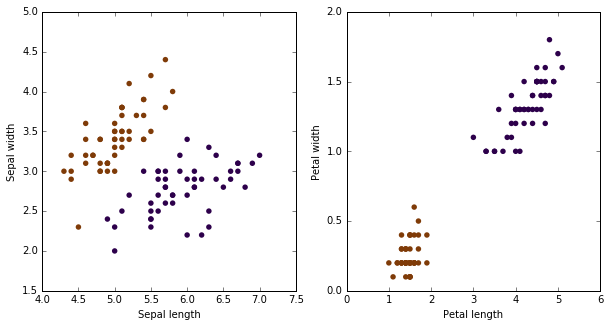

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [30]:
pred_iris = Clustering(2, 50).fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

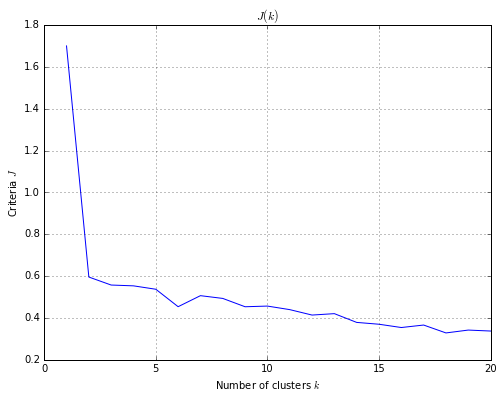

In [31]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k, 50)
    y = cls.fit_predict(x_iris)
    criteria[i] = quality(cls.mu, x_iris)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

In [27]:
def quality(centers, x):
    return sum(np.min(cdist(x, centers, 'euclidean'), axis=1)) / x.shape[0]

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

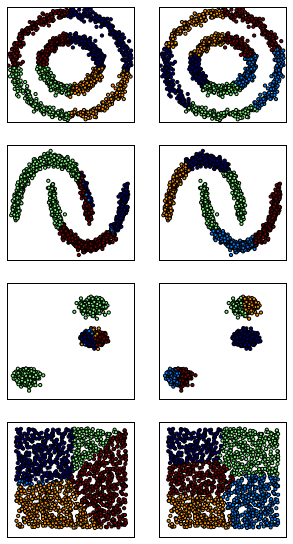

In [33]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]

i = 0;
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    k = 5
    cls = Clustering(k, 50)
    y = cls.fit_predict(X)
    
    plt.subplot(4, 2, i_dataset + 1 + i)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=y)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    
    GMM = GaussianMixture(n_components=k).fit(X)
    y_skl = GMM.predict(X)
    
    plt.subplot(4, 2, i_dataset + 2 + i)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=y_skl)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())
    
    i = i + 1

plt.show()